In [29]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [30]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

train.head()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 80 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

There are 7 features with more than 80% missing values


<Axes: title={'center': 'Percentage of missing values in the training data'}, xlabel='Features', ylabel='Percentage'>

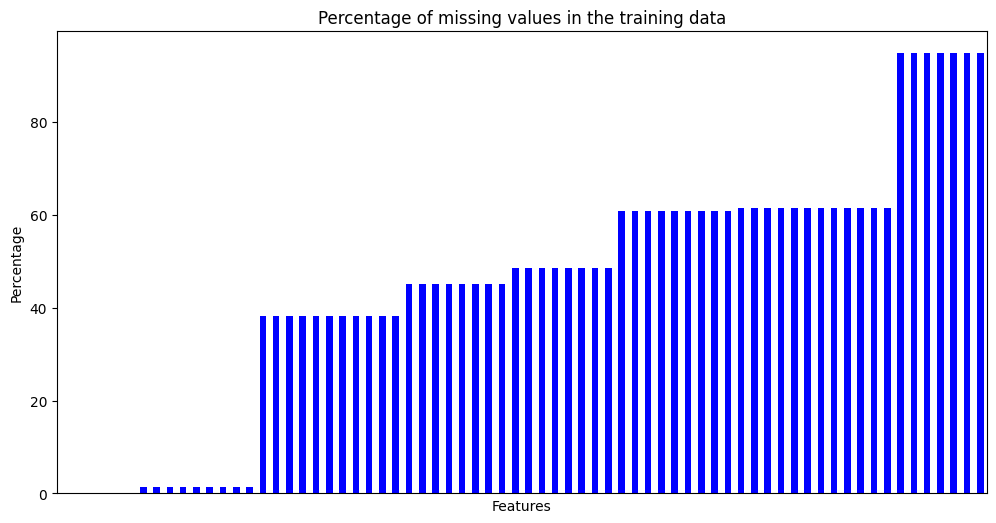

In [31]:
#plot the The percentage of available data for each feature
missing = (train.isnull().sum() / len(train)) * 100
missing = missing[missing > 0]
missing.sort_values(inplace=True)

#count number of missing features with 80%+
missing_features = missing[missing > 75].count()
print(f'There are {missing_features} features with more than 80% missing values')

#plot column names with 80%+ missing
# missing.plot.bar(figsize=(12, 6), color='blue', title='Percentage of missing values in the training data', ylabel='Percentage', xlabel='Features')

#plot the missing values with a good graph with a title without the x labels
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticks([])
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
missing.plot.bar(ax=ax, color='blue', title='Percentage of missing values in the training data', ylabel='Percentage', xlabel='Features')


In [32]:
#drop the columns less than 75% full
train = train.dropna(thresh=0.25*len(train), axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

In [33]:
#drop all rows with 50% of missing values
percentage_available = 0.75
train = train.dropna(thresh=(percentage_available)*len(train.columns), axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2987 entries, 4 to 8070
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        2987 non-null   object 
 1   site_id                                                   2987 non-null   object 
 2   site_latitude                                             2987 non-null   float64
 3   site_longitude                                            2987 non-null   float64
 4   city                                                      2987 non-null   object 
 5   country                                                   2987 non-null   object 
 6   date                                                      2987 non-null   object 
 7   hour                                                      2987 non-null   int64  
 8   sulphurdioxide_so2_colu

In [34]:
# combine city and country into one column
train['Location'] = train['country'] + ', ' + train['city']
train.drop(['country', 'city', 'id'], axis=1, inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2987 entries, 4 to 8070
Data columns (total 71 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   site_id                                                   2987 non-null   object 
 1   site_latitude                                             2987 non-null   float64
 2   site_longitude                                            2987 non-null   float64
 3   date                                                      2987 non-null   object 
 4   hour                                                      2987 non-null   int64  
 5   sulphurdioxide_so2_column_number_density                  2778 non-null   float64
 6   sulphurdioxide_so2_column_number_density_amf              2778 non-null   float64
 7   sulphurdioxide_so2_slant_column_number_density            2778 non-null   float64
 8   sulphurdioxide_cloud_fr

In [35]:
# Split the date column into day of the week, day of the month and year
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['day_of_month'] = train['date'].dt.day
train['year'] = train['date'].dt.year
train.drop('date', axis=1, inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2987 entries, 4 to 8070
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   site_id                                                   2987 non-null   object 
 1   site_latitude                                             2987 non-null   float64
 2   site_longitude                                            2987 non-null   float64
 3   hour                                                      2987 non-null   int64  
 4   sulphurdioxide_so2_column_number_density                  2778 non-null   float64
 5   sulphurdioxide_so2_column_number_density_amf              2778 non-null   float64
 6   sulphurdioxide_so2_slant_column_number_density            2778 non-null   float64
 7   sulphurdioxide_cloud_fraction                             2778 non-null   float64
 8   sulphurdioxide_sensor_a

# Some feature engineering 

We'll use this to later describe the relationship between site_id and pm2.5 and why we decided to include it in the dataset

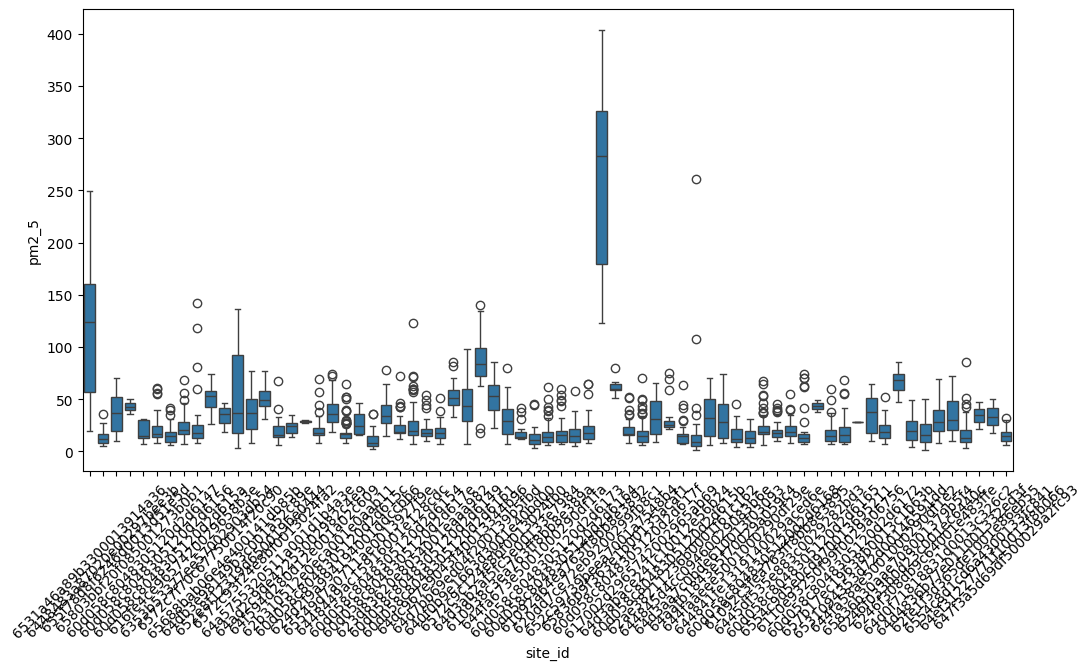

In [36]:
# show pm2_5 distributions based on the site_id
plt.figure(figsize=(12, 6))
sns.boxplot(x='site_id', y='pm2_5', data=train)
plt.xticks(rotation=45)
plt.show()

In [37]:
# One hot encode the Location and site_id columns
train = pd.get_dummies(train, columns=['site_id'])
train = pd.get_dummies(train, columns=['Location'])
train.head()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,day_of_week,day_of_month,year,site_id_60d058c8048305120d2d6147,site_id_60d058c8048305120d2d6149,site_id_60d058c8048305120d2d6154,site_id_60d058c8048305120d2d6156,site_id_60d058c8048305120d2d615a,site_id_60d058c8048305120d2d615b,site_id_60d058c8048305120d2d615c,site_id_60d058c8048305120d2d6161,site_id_60d058c8048305120d2d6164,site_id_60d058c8048305120d2d6165,site_id_60d058c8048305120d2d6168,site_id_60d058c8048305120d2d6172,site_id_60d058c8048305120d2d6173,site_id_60d058c8048305120d2d617e,site_id_60d058c8048305120d2d617f,site_id_61092a64ea763ff8bb8e3892,site_id_61092c3fea763ff8bb8e3895,site_id_610938c3ea763ff8bb8e389a,site_id_6110e93250f99f0029a06756,site_id_616fe4ce9657420029658b3e,site_id_617002d2965742002965ab69,site_id_620dd7ce72eb9200299fb8c1,site_id_623d83620e8054001eaaa982,site_id_6246f033b0d23c001ec6440c,site_id_6246f308db9c64001e483ffe,site_id_624d2f9a994194001ddccbb6,site_id_62ae38211236b0001f61c162,site_id_62b310512e0eca001e0aab11,site_id_62fe1f3d365de1001e86eb55,site_id_6353b53377ee57002903db54,site_id_640f0b9e1663d3001e40bd00,site_id_6445df535e883c0029282bd3,site_id_644841fe1319140029aced6e,site_id_6448449ac15916001e128cdc,site_id_644845d4cc09460029083b6e,site_id_6448483a87020e00297bee3b,site_id_644fa58ae5001000290df1e2,site_id_644fa673e5001000290df1fa,site_id_644faaeee5001000290df29e,site_id_647f3a5d69df500029a2fc93,site_id_64a5755320511a001d1b4a3e,site_id_64aafb1843e5f70029a059c4,site_id_64ad2c9de42253002982c4e9,site_id_64d0f71818831d0013c326c2,site_id_64d3aa7c0bde610013f03093,site_id_64d3ab2af5fc5e00133e7984,site_id_64d3abace241c10012e56b24,site_id_64d4836b77e011001332ed3f,site_id_64d7bb69ed04f200139b5fbd,site_id_64db3e98149b3c001a52c89e,site_id_64dc967e9043f40013344b96,site_id_64ef31227771f10013f8b066,site_id_64f594d280d12e001a02c609,site_i

In [38]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

columns = train.columns

train = pd.DataFrame(imputer.fit_transform(train), columns=columns, index=train.index)

train.describe()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,day_of_week,day_of_month,year,site_id_60d058c8048305120d2d6147,site_id_60d058c8048305120d2d6149,site_id_60d058c8048305120d2d6154,site_id_60d058c8048305120d2d6156,site_id_60d058c8048305120d2d615a,site_id_60d058c8048305120d2d615b,site_id_60d058c8048305120d2d615c,site_id_60d058c8048305120d2d6161,site_id_60d058c8048305120d2d6164,site_id_60d058c8048305120d2d6165,site_id_60d058c8048305120d2d6168,site_id_60d058c8048305120d2d6172,site_id_60d058c8048305120d2d6173,site_id_60d058c8048305120d2d617e,site_id_60d058c8048305120d2d617f,site_id_61092a64ea763ff8bb8e3892,site_id_61092c3fea763ff8bb8e3895,site_id_610938c3ea763ff8bb8e389a,site_id_6110e93250f99f0029a06756,site_id_616fe4ce9657420029658b3e,site_id_617002d2965742002965ab69,site_id_620dd7ce72eb9200299fb8c1,site_id_623d83620e8054001eaaa982,site_id_6246f033b0d23c001ec6440c,site_id_6246f308db9c64001e483ffe,site_id_624d2f9a994194001ddccbb6,site_id_62ae38211236b0001f61c162,site_id_62b310512e0eca001e0aab11,site_id_62fe1f3d365de1001e86eb55,site_id_6353b53377ee57002903db54,site_id_640f0b9e1663d3001e40bd00,site_id_6445df535e883c0029282bd3,site_id_644841fe1319140029aced6e,site_id_6448449ac15916001e128cdc,site_id_644845d4cc09460029083b6e,site_id_6448483a87020e00297bee3b,site_id_644fa58ae5001000290df1e2,site_id_644fa673e5001000290df1fa,site_id_644faaeee5001000290df29e,site_id_647f3a5d69df500029a2fc93,site_id_64a5755320511a001d1b4a3e,site_id_64aafb1843e5f70029a059c4,site_id_64ad2c9de42253002982c4e9,site_id_64d0f71818831d0013c326c2,site_id_64d3aa7c0bde610013f03093,site_id_64d3ab2af5fc5e00133e7984,site_id_64d3abace241c10012e56b24,site_id_64d4836b77e011001332ed3f,site_id_64d7bb69ed04f200139b5fbd,site_id_64db3e98149b3c001a52c89e,site_id_64dc967e9043f40013344b96,site_id_64ef31227771f10013f8b066,site_id_64f594d280d12e001a02c609,site_i

## Feature Engineering

In [39]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train)

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

KeyError: 'date'

In [ ]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train, hue='Location')

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

In [ ]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='month', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

In [ ]:
# lets check the correlation of the hour and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='hour', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

# Drop the hour column
train = train.drop(columns=['hour'])

In [40]:
# list non-categorical columns
non_categorical = train.select_dtypes(include=[np.number]).columns
# remove hour, month, latitude and longitude from this list
non_categorical = non_categorical.drop(['hour', 'month', 'site_latitude', 'site_longitude', 'pm2_5'])
non_categorical

Index(['sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km',
       'carbonmonoxide_co_column_number_density',
       ...
       'site_id_6572c93f24e8bf0013024fa2', 'site_id_6572c9c124e8bf0013024fb0',
       'site_id_657b17ec19638b0013c1b63b', 'site_id_65803bbf20f085001273b0b1',
       'site_id_65836b30aae708001379b5f4', 'site_id_65836b9f363e1b00135acaf1',
       'Location_Burundi, Bujumbura', 'Location_Kenya, Nairobi',
       'Location_Nigeria, Lagos', 'Location_Uganda, Kampala'],
      dtype='object', length=139)

In [ ]:
#apply transformation to pm2_5 level to reduce skewness

#plot day of the week vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='day_of_week', y='pm2_5', data=train)
plt.title('Day of the week vs pm2_5')
plt.show()

#plot day of the month vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='day_of_month', y='pm2_5', data=train)
plt.title('Day of the month vs pm2_5')
plt.show()

#plot year vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='pm2_5', data=train)
plt.title('Year vs pm2_5')
plt.show()


# Now we are training the regression model

In [ ]:
train.head()

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd


# Normalization
scaler = StandardScaler()
# scale the columns in the non-categorical columns list
train[non_categorical] = scaler.fit_transform(train[non_categorical])

train.head()


,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,day_of_week,day_of_month,year,site_id_60d058c8048305120d2d6147,site_id_60d058c8048305120d2d6149,site_id_60d058c8048305120d2d6154,site_id_60d058c8048305120d2d6156,site_id_60d058c8048305120d2d615a,site_id_60d058c8048305120d2d615b,site_id_60d058c8048305120d2d615c,site_id_60d058c8048305120d2d6161,site_id_60d058c8048305120d2d6164,site_id_60d058c8048305120d2d6165,site_id_60d058c8048305120d2d6168,site_id_60d058c8048305120d2d6172,site_id_60d058c8048305120d2d6173,site_id_60d058c8048305120d2d617e,site_id_60d058c8048305120d2d617f,site_id_61092a64ea763ff8bb8e3892,site_id_61092c3fea763ff8bb8e3895,site_id_610938c3ea763ff8bb8e389a,site_id_6110e93250f99f0029a06756,site_id_616fe4ce9657420029658b3e,site_id_617002d2965742002965ab69,site_id_620dd7ce72eb9200299fb8c1,site_id_623d83620e8054001eaaa982,site_id_6246f033b0d23c001ec6440c,site_id_6246f308db9c64001e483ffe,site_id_624d2f9a994194001ddccbb6,site_id_62ae38211236b0001f61c162,site_id_62b310512e0eca001e0aab11,site_id_62fe1f3d365de1001e86eb55,site_id_6353b53377ee57002903db54,site_id_640f0b9e1663d3001e40bd00,site_id_6445df535e883c0029282bd3,site_id_644841fe1319140029aced6e,site_id_6448449ac15916001e128cdc,site_id_644845d4cc09460029083b6e,site_id_6448483a87020e00297bee3b,site_id_644fa58ae5001000290df1e2,site_id_644fa673e5001000290df1fa,site_id_644faaeee5001000290df29e,site_id_647f3a5d69df500029a2fc93,site_id_64a5755320511a001d1b4a3e,site_id_64aafb1843e5f70029a059c4,site_id_64ad2c9de42253002982c4e9,site_id_64d0f71818831d0013c326c2,site_id_64d3aa7c0bde610013f03093,site_id_64d3ab2af5fc5e00133e7984,site_id_64d3abace241c10012e56b24,site_id_64d4836b77e011001332ed3f,site_id_64d7bb69ed04f200139b5fbd,site_id_64db3e98149b3c001a52c89e,site_id_64dc967e9043f40013344b96,site_id_64ef31227771f10013f8b066,site_id_64f594d280d12e001a02c609,site_i

In [42]:
# Split the data into training and testing sets
X = train.drop(columns=['pm2_5'])

y = train['pm2_5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Train RMSE: 13.932009590428393
Test RMSE: 11.442769778574958


Text(0.5, 1.0, 'Actual vs Predicted values')

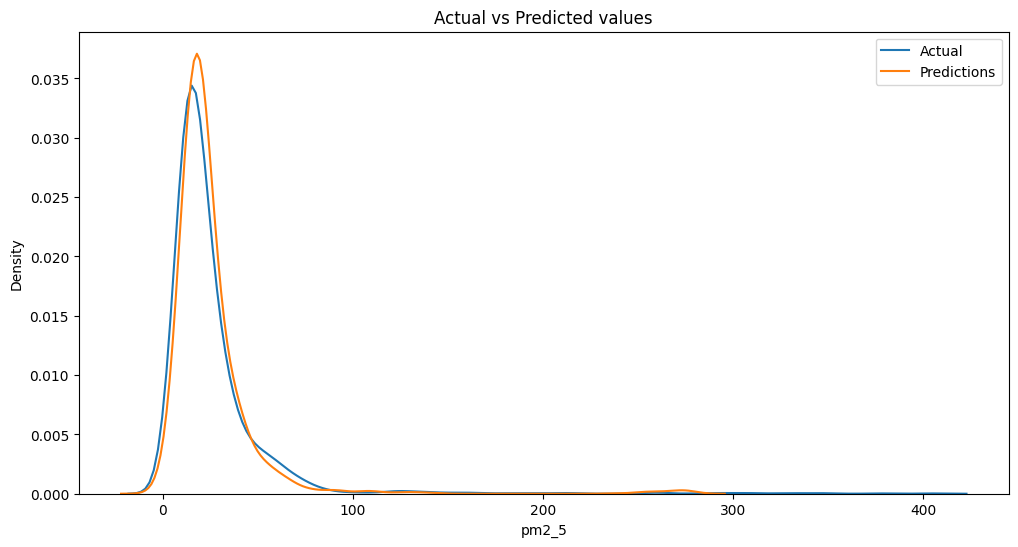

In [43]:
# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1269.3167 - val_loss: 249.5700
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 574.6581 - val_loss: 220.5417
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 740.7156 - val_loss: 170.1214
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 478.6312 - val_loss: 162.0668
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 474.2957 - val_loss: 124.0796
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 400.1010 - val_loss: 118.1844
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 296.0879 - val_loss: 108.3671
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 298.6187 - val_loss: 120.9948
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 269.1683 - val_loss: 111.3181
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 234.3928 - val_loss: 115.5574
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 207.9391 - val_loss: 112.935

Text(0.5, 1.0, 'Actual vs Predicted values')

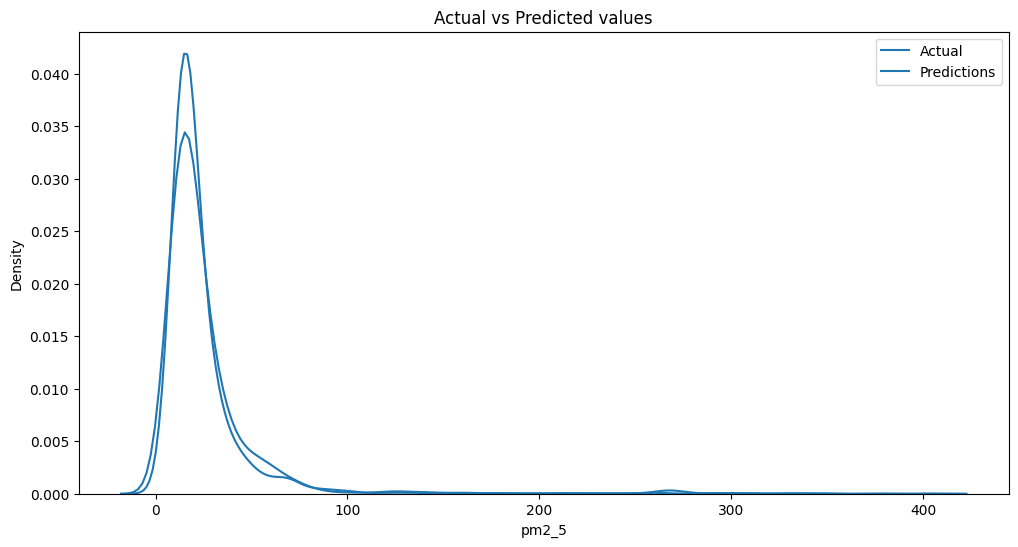

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Define the neural network architecture
model = Sequential()
#add dropout layer

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with single node for regression

early_stop = EarlyStopping(monitor='val_loss', patience=10) 

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')

In [46]:
#random forest tree
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Assess the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')



Train RMSE: 5.254383126607241
Test RMSE: 8.640919079659051


In [47]:
X_train.columns = X_train.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

In [48]:
model = LGBMRegressor()
model.fit(X_train, y_train)

# Local score
y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16407
[LightGBM] [Info] Number of data points in the train set: 2389, number of used features: 120
[LightGBM] [Info] Start training from score 25.579425
Local RMSE: 10.154816880894012


In [ ]:

# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

In [ ]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

- The target variable has some outliers that are beyond the 180 mark.
- Outliers can be handled via
  - Dropping them
  - Cap outliers - set a maximum
  - Assign a new value to the outliers
  - Transform the target variable


In [ ]:
# print a summary of each variable
train.describe()

In [ ]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()